<a href="https://colab.research.google.com/github/jsebastianquiroga/IMAGE_VIDEO_PROCESSING_PUJ/blob/main/proyecto/proyecto_garcia_quiroga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instalar la API de Kaggle
!pip install -q kaggle

In [3]:
# Descargar el archivo kaggle.json desde tu repositorio de GitHub
!wget https://raw.githubusercontent.com/jsebastianquiroga/IMAGE_VIDEO_PROCESSING_PUJ/main/proyecto/kaggle.json

# Preparar el archivo de credenciales
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Descargar el conjunto de datos
!kaggle datasets download -d kmader/mias-mammography
# !kaggle datasets download -d quachnam/mias-roi-mammography

# Descomprimir el conjunto de datos
!unzip mias-mammography.zip
# !unzip mias-roi-mammography.zip

--2023-10-18 01:44:59--  https://raw.githubusercontent.com/jsebastianquiroga/IMAGE_VIDEO_PROCESSING_PUJ/main/proyecto/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68 [text/plain]
Saving to: ‘kaggle.json’

kaggle.json         100%[===================>]      68  --.-KB/s    in 0s      

2023-10-18 01:44:59 (4.08 MB/s) - ‘kaggle.json’ saved [68/68]

 95% 296M/312M [00:01<00:00, 155MB/s]
100% 312M/312M [00:01<00:00, 187MB/s]
Archive:  mias-mammography.zip
  inflating: Info.txt                
  inflating: all-mias.tar.gz         
  inflating: all-mias/Info.txt       
  inflating: all-mias/Licence.txt    
  inflating: all-mias/README         
  inflating: all-mias/mdb001.pgm     
  inflating: all-mias/mdb002.pgm     
  inflating: all-mias/mdb003.pg

# Muestreo.

Se toma el top 50  para el procesamiento.

In [4]:
import os
import random
import cv2
import matplotlib.pyplot as plt

# Listar todas las imágenes disponibles
all_images = os.listdir('all-mias')

# Muestrear 50 imágenes aleatoriamente
sampled_images = random.sample(all_images, 50)

In [5]:
import shutil
import os
from google.colab import drive
drive.mount('/content/drive')

def copy_to_drive(drive_path, local_path):
    # Check if the directory exists. If not, create it.
    if not os.path.exists(drive_path):
        os.makedirs(drive_path)

    # Copy individual files from local folder to Google Drive folder
    for file in os.listdir(local_path):
        shutil.copy(os.path.join(local_path, file), drive_path)

# Crear la carpeta "muestreo" si no existe
if not os.path.exists('./muestreo'):
    os.makedirs('./muestreo')

# Copiar las imágenes muestreadas a la carpeta "muestreo"
for image in sampled_images:
    shutil.copy(os.path.join('all-mias', image), './muestreo')

# Especifica la ruta directamente a la carpeta en tu Google Drive
drive_path = '/content/drive/My Drive/19sU2JfSIY5OZVyJyRqFvLZAaS0um5R4f/muestreo'

# Ahora, utiliza la función copy_to_drive que definimos anteriormente para copiar la carpeta a Google Drive
copy_to_drive(drive_path, "./muestreo")

Mounted at /content/drive


# EDA

In [6]:
import pandas as pd
import numpy as np
import scipy
import glob
import seaborn as sns
import matplotlib.image as mpimg

df = pd.read_csv('/content/Info.txt', sep=" ").drop('Unnamed: 7',axis=1)
df.head(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0


In [7]:
# Crear la columna con las rutas completas de las imágenes
df['IMAGE_PATH'] = df['REFNUM'].apply(lambda x: os.path.join("/content/all-mias", f"{x}.pgm"))

In [8]:
# Comprobación: imprimir las primeras 5 rutas para asegurarse de que estén correctas
df.head(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,IMAGE_PATH
0,mdb001,G,CIRC,B,535.0,425.0,197.0,/content/all-mias/mdb001.pgm
1,mdb002,G,CIRC,B,522.0,280.0,69.0,/content/all-mias/mdb002.pgm
2,mdb003,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb003.pgm
3,mdb004,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb004.pgm
4,mdb005,F,CIRC,B,477.0,133.0,30.0,/content/all-mias/mdb005.pgm


In [9]:
# Comprobación: imprimir las últimas 5 rutas para asegurarse de que estén correctas
df.tail(5)

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS,IMAGE_PATH
325,mdb318,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb318.pgm
326,mdb319,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb319.pgm
327,mdb320,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb320.pgm
328,mdb321,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb321.pgm
329,mdb322,D,NORM,NaN,NaN,NaN,NaN,/content/all-mias/mdb322.pgm


In [10]:
# Crear las clases 0 si es NORMAL y 1 para el resto
df['CLASS'] = [0 if x == 'NORM' else 1 for x in df['CLASS']]

In [11]:
labels = df.drop_duplicates(subset=['REFNUM'])['CLASS'].astype('category')
print(labels.value_counts())

0    207
1    115
Name: CLASS, dtype: int64


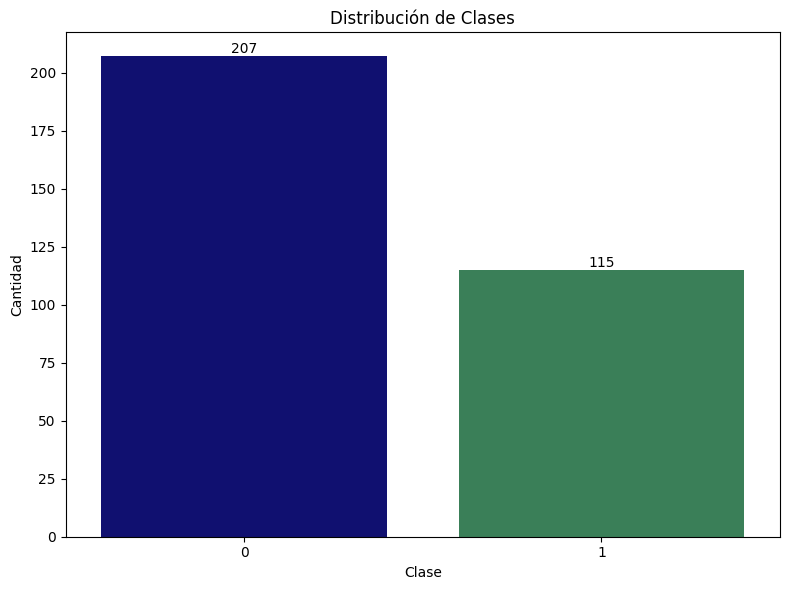

In [12]:
# Pintar el gráfico de barras con seaborn
plt.figure(figsize=(8, 6))
ax = sns.countplot(x=labels, palette={0: "navy", 1: "seagreen"})

# Añadir las etiquetas a las barras
ax.bar_label(ax.containers[0])

plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

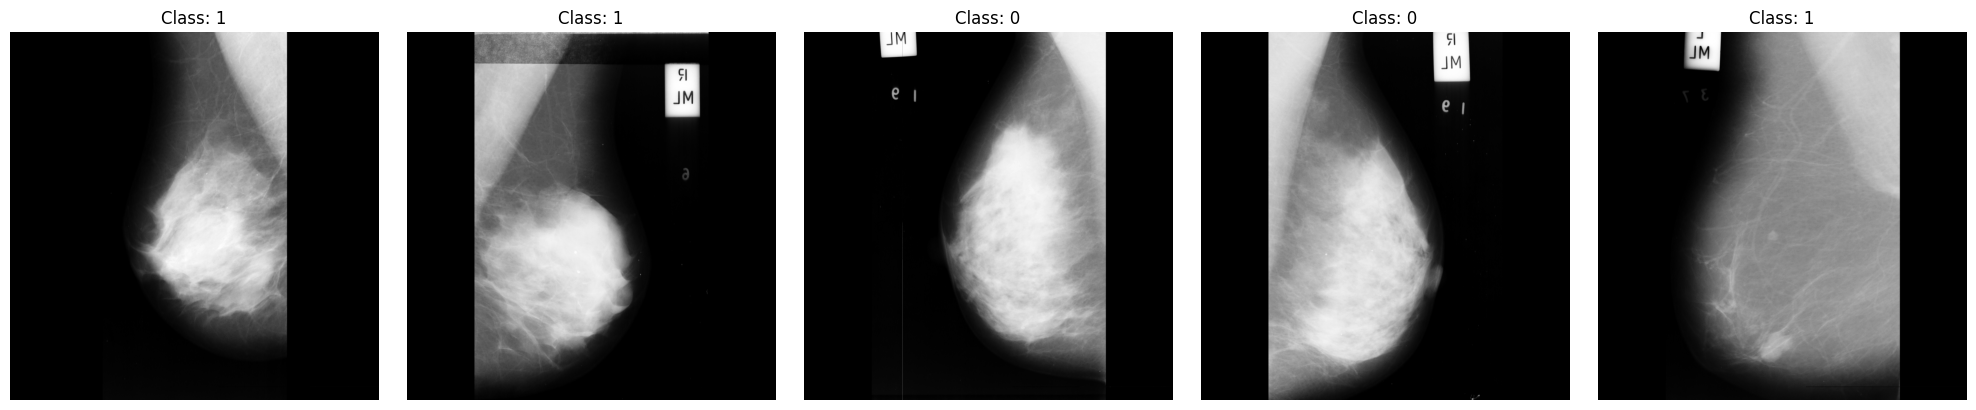

In [13]:
# Cargar y visualizar algunas imágenes (ej: las primeras 5)
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for ax, (_, row) in zip(axes, df.head(5).iterrows()):
    image = cv2.imread(row['IMAGE_PATH'], cv2.IMREAD_GRAYSCALE)
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Class: {row['CLASS']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Aplicar técnicas de procesamiento de imágenes

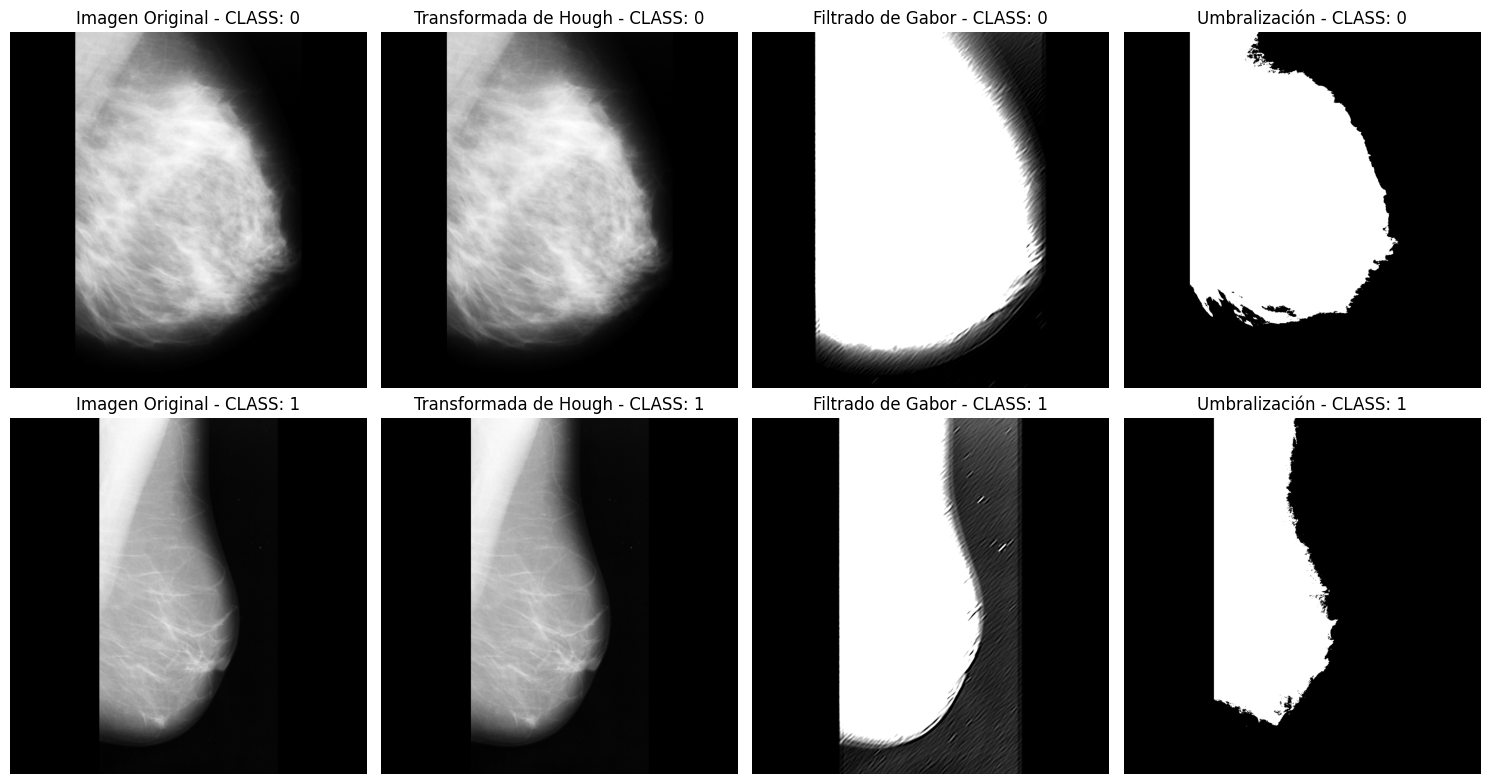

In [14]:
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Crear la carpeta "muestreo" si no existe
if not os.path.exists('./muestreo'):
    os.makedirs('./muestreo')

# Copiar las imágenes muestreadas a la carpeta "muestreo"
for image in sampled_images:
    shutil.copy(os.path.join('all-mias', image), './muestreo')

# Ahora, utiliza la función copy_to_drive que definimos anteriormente para copiar la carpeta a Google Drive
copy_to_drive("19sU2JfSIY5OZVyJyRqFvLZAaS0um5R4f", "./muestreo")

# Seleccionar al azar una imagen con CLASS = 0
random_image_0_refnum = df[df['CLASS'] == 0].sample(1)['REFNUM'].iloc[0]
random_image_path_0 = os.path.join('all-mias', f"{random_image_0_refnum}.pgm")
image_0 = cv2.imread(random_image_path_0, cv2.IMREAD_GRAYSCALE)

# Seleccionar al azar una imagen con CLASS = 1
random_image_1_refnum = df[df['CLASS'] == 1].sample(1)['REFNUM'].iloc[0]
random_image_path_1 = os.path.join('all-mias', f"{random_image_1_refnum}.pgm")
image_1 = cv2.imread(random_image_path_1, cv2.IMREAD_GRAYSCALE)

# Mostrar las imágenes en una grilla
fig, ax = plt.subplots(2, 4, figsize=(15, 8))

def process_and_show(ax_row, image, class_label):

    # La iamgén original para comparación
    ax_row[0].imshow(image, cmap='gray')
    ax_row[0].set_title(f'Imagen Original - CLASS: {class_label}')
    ax_row[0].axis('off')

    # Transformada de Hough (solo mostraremos los bordes detectados aquí)
    edges = cv2.Canny(image, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
    if lines is not None:
        for rho,theta in lines[:,0]:
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    ax_row[1].imshow(image, cmap='gray')
    ax_row[1].set_title(f'Transformada de Hough - CLASS: {class_label}')
    ax_row[1].axis('off')

    # Filtrado de Gabor
    gabor_filter = cv2.getGaborKernel((21, 21), 5.0, np.pi/4, 10.0, 0.5, 0, ktype=cv2.CV_32F)
    gabor_image = cv2.filter2D(image, cv2.CV_8UC3, gabor_filter)
    ax_row[2].imshow(gabor_image, cmap='gray')
    ax_row[2].set_title(f'Filtrado de Gabor - CLASS: {class_label}')
    ax_row[2].axis('off')

    # Segmentación basada en umbralización
    _, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    ax_row[3].imshow(thresh, cmap='gray')
    ax_row[3].set_title(f'Umbralización - CLASS: {class_label}')
    ax_row[3].axis('off')

process_and_show(ax[0], image_0, 0)
process_and_show(ax[1], image_1, 1)

plt.tight_layout()
plt.show()

In [15]:
print(f"Imagen seleccionada al azar con CLASS = 0: {random_image_0_refnum}.pgm")
print(f"Imagen seleccionada al azar con CLASS = 1: {random_image_1_refnum}.pgm")

Imagen seleccionada al azar con CLASS = 0: mdb296.pgm
Imagen seleccionada al azar con CLASS = 1: mdb080.pgm


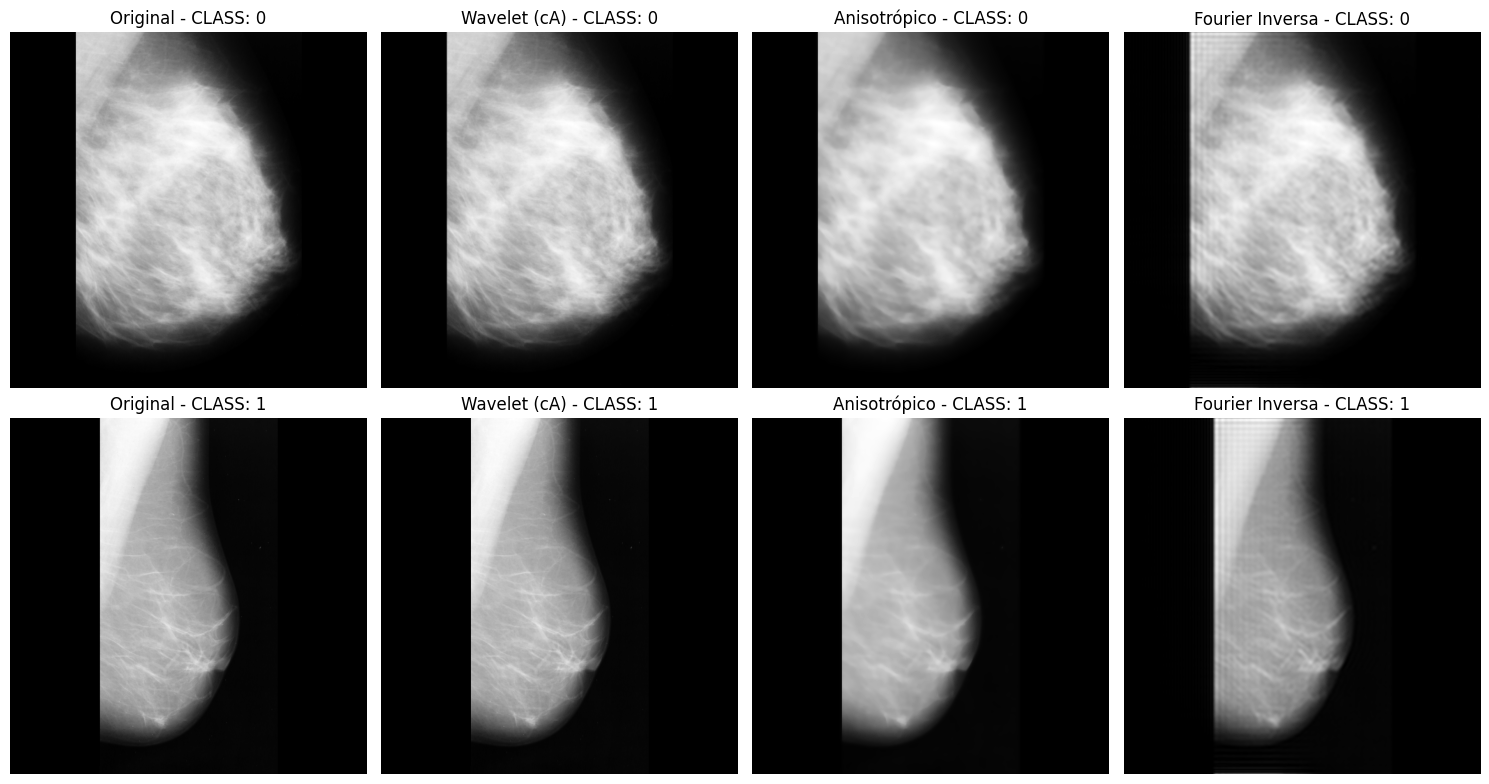

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from skimage.restoration import denoise_tv_chambolle

# Mostrar las imágenes en una grilla
fig, ax = plt.subplots(2, 4, figsize=(15, 8))

def process_and_show(ax_row, image, class_label):

    # Imagen Original
    ax_row[0].imshow(image, cmap='gray')
    ax_row[0].set_title(f'Original - CLASS: {class_label}')
    ax_row[0].axis('off')

    # Transformada Wavelet
    coeffs = pywt.dwt2(image, 'db1')
    cA, (cH, cV, cD) = coeffs
    ax_row[1].imshow(cA, cmap='gray')
    ax_row[1].set_title(f'Wavelet (cA) - CLASS: {class_label}')
    ax_row[1].axis('off')

    # Filtrado Anisotrópico
    aniso_filtered = denoise_tv_chambolle(image, weight=0.1)
    ax_row[2].imshow(aniso_filtered, cmap='gray')
    ax_row[2].set_title(f'Anisotrópico - CLASS: {class_label}')
    ax_row[2].axis('off')

    # Transformada de Fourier y filtrado paso-bajo
    f_transform = np.fft.fftshift(np.fft.fft2(image))

    # Aplica un filtro paso-bajo
    rows, cols = f_transform.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols), np.uint8)
    cutoff = 60  # Se puede ajustar este valor
    mask[crow - cutoff:crow + cutoff, ccol - cutoff:ccol + cutoff] = 1
    f_transform = f_transform * mask

    # Invertir la transformada para obtener la imagen modificada
    inverse_transform = np.abs(np.fft.ifft2(np.fft.ifftshift(f_transform)))

    ax_row[3].imshow(inverse_transform, cmap='gray')
    ax_row[3].set_title(f'Fourier Inversa - CLASS: {class_label}')
    ax_row[3].axis('off')

process_and_show(ax[0], image_0, 0)
process_and_show(ax[1], image_1, 1)

plt.tight_layout()
plt.show()

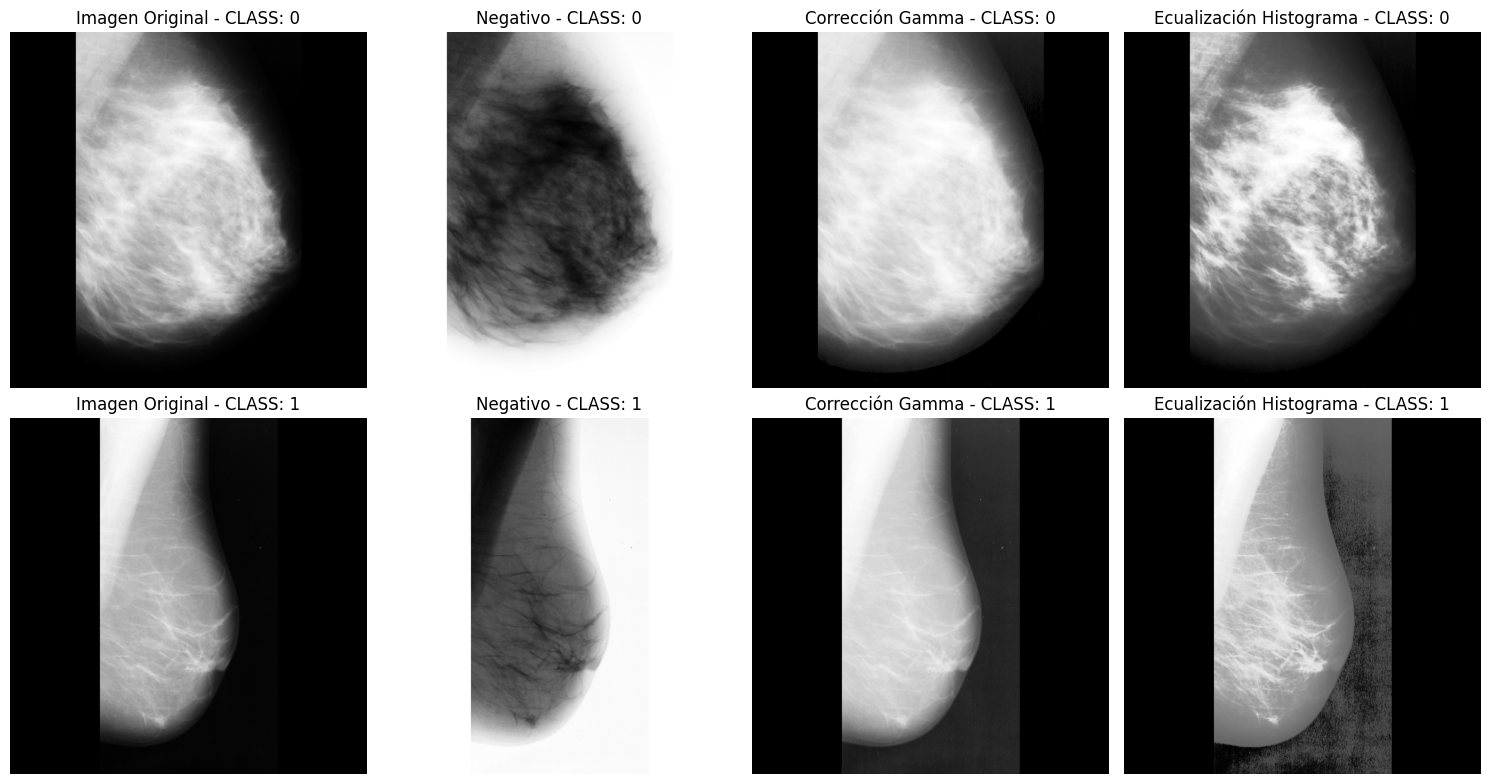

In [17]:
# Mostrar las imágenes en una grilla
fig, ax = plt.subplots(2, 4, figsize=(15, 8))

def process_and_show(ax_row, image, class_label):

    # La imagen original para comparación
    ax_row[0].imshow(image, cmap='gray')
    ax_row[0].set_title(f'Imagen Original - CLASS: {class_label}')
    ax_row[0].axis('off')

    # Negativo de la imagen
    negative_image = 255 - image
    ax_row[1].imshow(negative_image, cmap='gray')
    ax_row[1].set_title(f'Negativo - CLASS: {class_label}')
    ax_row[1].axis('off')

    # Corrección Gamma
    gamma = 0.5  # Se puede ajustar este valor
    gamma_corrected = np.array(255*(image/255)**gamma, dtype = 'uint8')
    ax_row[2].imshow(gamma_corrected, cmap='gray')
    ax_row[2].set_title(f'Corrección Gamma - CLASS: {class_label}')
    ax_row[2].axis('off')

    # Ecualización del histograma
    equalized_image = cv2.equalizeHist(image)
    ax_row[3].imshow(equalized_image, cmap='gray')
    ax_row[3].set_title(f'Ecualización Histograma - CLASS: {class_label}')
    ax_row[3].axis('off')

process_and_show(ax[0], image_0, 0)
process_and_show(ax[1], image_1, 1)

plt.tight_layout()
plt.show()

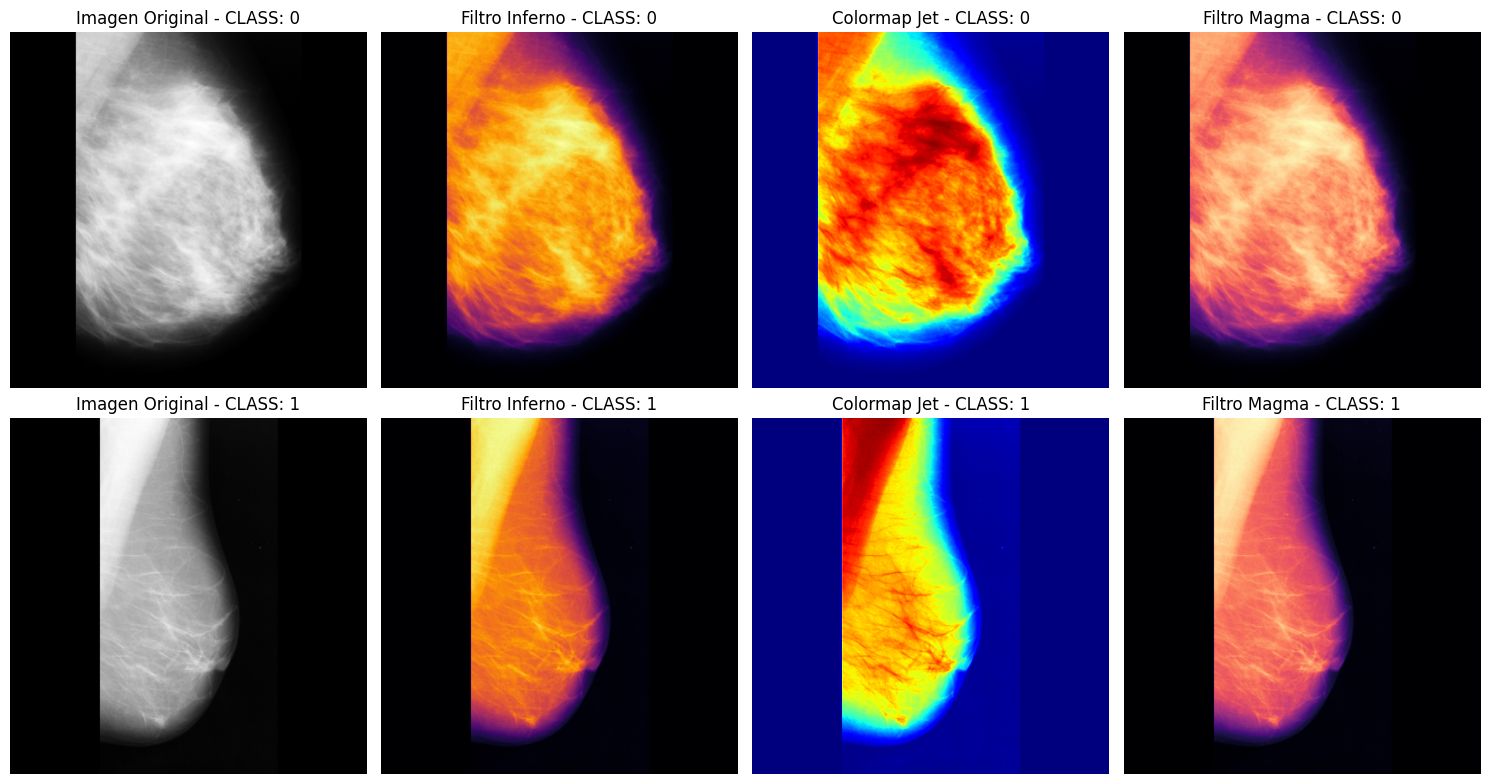

In [18]:
# Mostrar las imágenes en una grilla
fig, ax = plt.subplots(2, 4, figsize=(15, 8))

def process_and_show(ax_row, image, class_label):

    # La imagen original para comparación
    ax_row[0].imshow(image, cmap='gray')
    ax_row[0].set_title(f'Imagen Original - CLASS: {class_label}')
    ax_row[0].axis('off')

    # Aplicar el filtro Inferno
    ax_row[1].imshow(image, cmap='inferno')
    ax_row[1].set_title(f'Filtro Inferno - CLASS: {class_label}')
    ax_row[1].axis('off')

    # Colormap Jet
    ax_row[2].imshow(image, cmap='jet')
    ax_row[2].set_title(f'Colormap Jet - CLASS: {class_label}')
    ax_row[2].axis('off')

    # Aplicar el filtro Magma
    ax_row[3].imshow(image, cmap='magma')
    ax_row[3].set_title(f'Filtro Magma - CLASS: {class_label}')
    ax_row[3].axis('off')

process_and_show(ax[0], image_0, 0)
process_and_show(ax[1], image_1, 1)

plt.tight_layout()
plt.show()


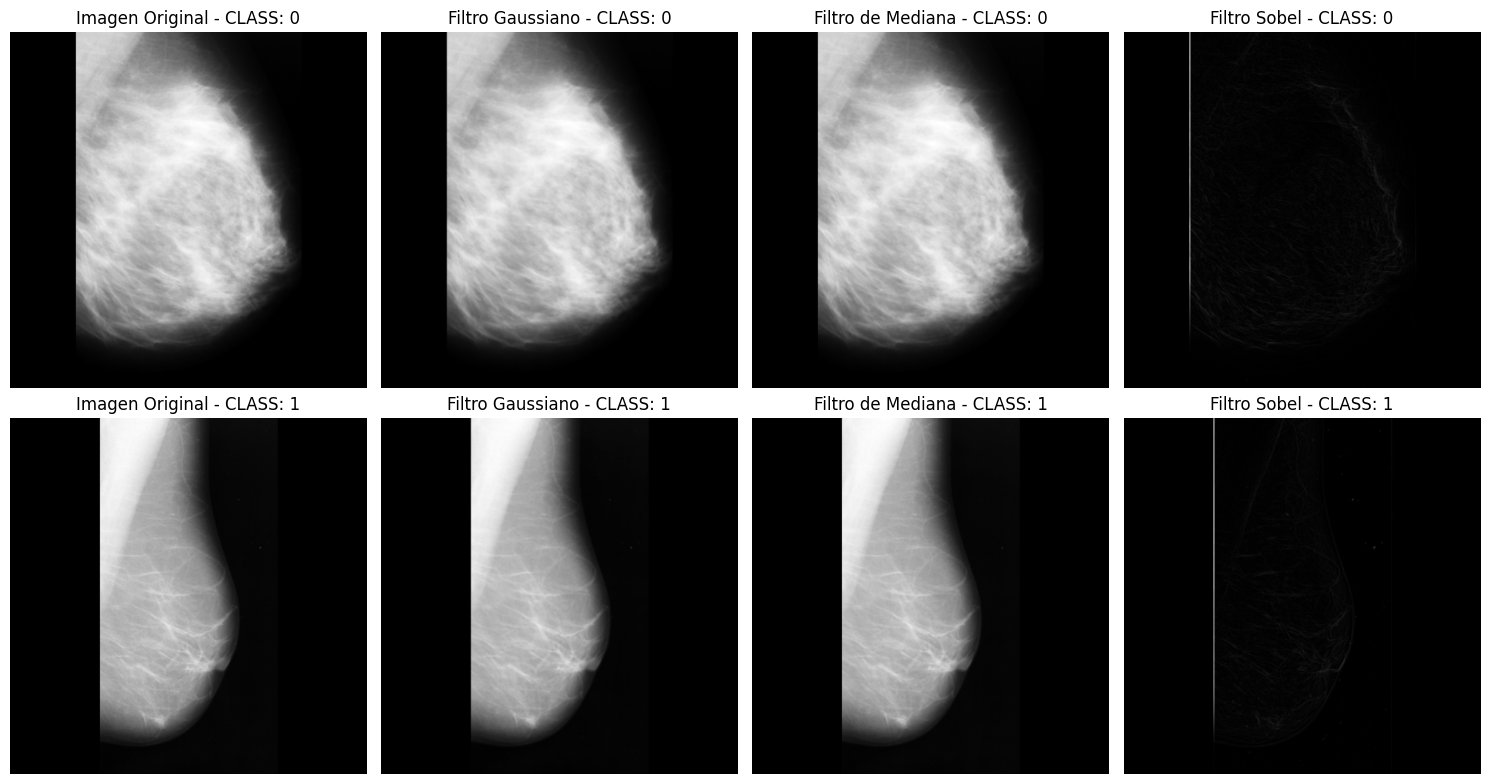

In [19]:
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter, median_filter
from matplotlib import pyplot as plt

# Mostrar las imágenes en una grilla
fig, ax = plt.subplots(2, 4, figsize=(15, 8))

def process_and_show(ax_row, image, class_label):

    # La imagen original para comparación
    ax_row[0].imshow(image, cmap='gray')
    ax_row[0].set_title(f'Imagen Original - CLASS: {class_label}')
    ax_row[0].axis('off')

    # Aplicar filtro Gaussiano para suavizado
    gaussian_blur = gaussian_filter(image, sigma=1)
    ax_row[1].imshow(gaussian_blur, cmap='gray')
    ax_row[1].set_title(f'Filtro Gaussiano - CLASS: {class_label}')
    ax_row[1].axis('off')

    # Aplicar filtro de Mediana para reducción de ruido
    median_blur = median_filter(image, size=3)
    ax_row[2].imshow(median_blur, cmap='gray')
    ax_row[2].set_title(f'Filtro de Mediana - CLASS: {class_label}')
    ax_row[2].axis('off')

    # Aplicar filtro de detección de bordes (Sobel)
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    sobel_edges = np.hypot(sobelx, sobely)
    ax_row[3].imshow(sobel_edges, cmap='gray')
    ax_row[3].set_title(f'Filtro Sobel - CLASS: {class_label}')
    ax_row[3].axis('off')

process_and_show(ax[0], image_0, 0)
process_and_show(ax[1], image_1, 1)

plt.tight_layout()
plt.show()


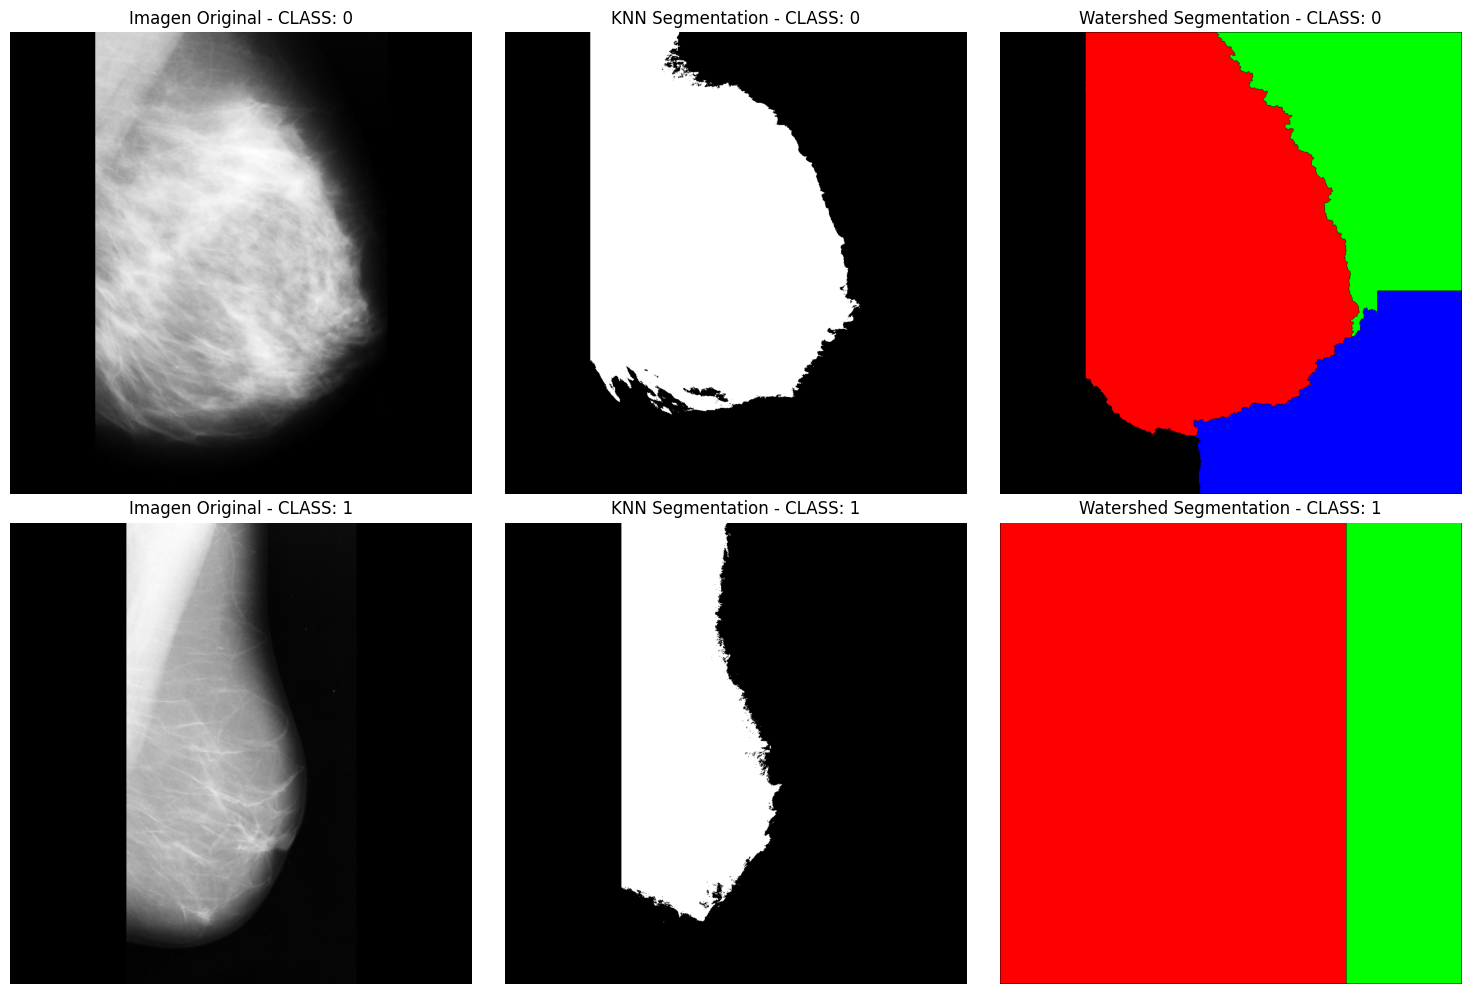

In [21]:
import cv2
import numpy as np
from sklearn import neighbors
from matplotlib import pyplot as plt

def resize_image(image, scale=0.5):
    return cv2.resize(image, (int(image.shape[1] * scale), int(image.shape[0] * scale)))

def knn_segmentation(image, labels, n_neighbors=3):
    flat_image = image.reshape(-1, 1)
    flat_labels = labels.reshape(-1)
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(flat_image, flat_labels)
    predicted_labels = knn.predict(flat_image)
    segmented_image = predicted_labels.reshape(image.shape)
    return segmented_image

def watershed_segmentation(image):
    # Convert to 3-channel color if not already
    if len(image.shape) == 2 or image.shape[2] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)
    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers.astype(np.int32) + 1  # Ensure it's int32 type
    markers[unknown == 255] = 0
    markers = cv2.watershed(image, markers)
    image[markers == -1] = [0, 0, 255]
    return image, markers


def assign_colors_to_markers(markers):
    colored_image = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)
    colored_image[markers == 1] = [255, 0, 0]  # Red for label 1
    colored_image[markers == 2] = [0, 255, 0]  # Green for label 2
    colored_image[markers == 3] = [0, 0, 255]  # Blue for label 3
    return colored_image

def process_and_show(ax_row, image, class_label):
    ax_row[0].imshow(image, cmap='gray')
    ax_row[0].set_title(f'Imagen Original - CLASS: {class_label}')
    ax_row[0].axis('off')

    labels = (image > 127).astype(int)
    knn_seg_image = knn_segmentation(image, labels)
    ax_row[1].imshow(knn_seg_image, cmap='gray')
    ax_row[1].set_title(f'KNN Segmentation - CLASS: {class_label}')
    ax_row[1].axis('off')

    watershed_img, markers = watershed_segmentation(image.copy())
    colored_watershed = assign_colors_to_markers(markers)
    ax_row[2].imshow(colored_watershed)
    ax_row[2].set_title(f'Watershed Segmentation - CLASS: {class_label}')
    ax_row[2].axis('off')

# Adjusting the subplot for the number of examples and methods
num_examples = 2  # Adjust this based on your total number of examples
fig, ax = plt.subplots(num_examples, 3, figsize=(15, 5 * num_examples))

process_and_show(ax[0], image_0, 0)
process_and_show(ax[1], image_1, 1)

plt.tight_layout()
plt.show()